In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras import Sequential, layers, Input, regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical

from scripts.data_cleaner import filter_top_cpv_categories
from scripts.preprocess_pipeline import create_pipeline



2025-06-11 12:13:44.873386: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-11 12:13:44.874076: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-11 12:13:44.878279: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-11 12:13:44.887326: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749636824.901842   60393 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749636824.90

In [2]:
DATA_PATH = os.path.join(os.path.dirname(os.getcwd()),
                        'data')
MODEL_PATH = os.path.join(os.path.dirname(os.getcwd()),
                            'models', 'estimation')
os.makedirs(MODEL_PATH, exist_ok=True)

df = pd.read_csv(os.path.join(DATA_PATH,'data_clean.csv'))

/tmp/ipykernel_60393/3993587178.py:7: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_PATH,'data_clean.csv'))


In [3]:
df = filter_top_cpv_categories(df, top_n=150, cpv_column='codeCPV_3')
df.drop(df[df['montant'] > 999_999].index, inplace=True)

y = np.log1p(df['montant'])


bins = np.linspace(y.min(), y.max(), 101)
#bins = np.delete(bins, 1)

#bins = bins[2:]

# Créer les étiquettes correspondantes
labels = list(range(0, len(bins)-1))

# Ajouter la colonne fourchette_de_prix
df['bins'] = pd.cut(y, bins=bins, labels=labels, include_lowest=True, right=True)

df['bins'] = df['bins'].astype('int')
df = df.drop(columns='montant')

X = df.drop(columns=['bins', 'titulaire_tranche_effectif', 'titulaire_categorie'])
y = df['bins']

df[['acheteur_tranche_effectif', 'acheteur_categorie']] = df[['acheteur_tranche_effectif', 'acheteur_categorie']].fillna('null')


Filtered from 392 to 150 CPV categories, keeping 279174 rows out of 286850


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=X['codeCPV_3'])

numerical_columns = ['dureeMois', 'offresRecues', 'annee']

binary_columns = ['sousTraitanceDeclaree', 'origineFrance',
                          'marcheInnovant', 'idAccordCadre']

categorical_columns = ['procedure', 'nature', 'formePrix', 'ccag',
                               'typeGroupementOperateurs', 'tauxAvance_cat',
                               'codeCPV_3', 'acheteur_tranche_effectif', 'acheteur_categorie']

pipeline = create_pipeline(numerical_columns, binary_columns, categorical_columns)

X_train_preproc = pipeline.fit_transform(X_train)

y_train_cat = to_categorical(y_train)

In [5]:
y_train_cat.shape

(190530, 100)

In [6]:
def build_mlp_model(input_dim=220, num_classes=100, use_dropout=True, l2_factor=1e-4):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))

    # Couche 1
    model.add(layers.Dense(
        1028, activation='relu',
        kernel_regularizer=regularizers.l2(l2_factor)
    ))
    model.add(layers.BatchNormalization())
    if use_dropout:
        model.add(layers.Dropout(0.4))

    # Couche 2
    model.add(layers.Dense(
        512, activation='relu',
        kernel_regularizer=regularizers.l2(l2_factor)
    ))
    model.add(layers.BatchNormalization())
    if use_dropout:
        model.add(layers.Dropout(0.3))

    # Couche 3
    model.add(layers.Dense(
        256, activation='relu',
        kernel_regularizer=regularizers.l2(l2_factor)
    ))
    model.add(layers.BatchNormalization())
    if use_dropout:
        model.add(layers.Dropout(0.2))

    # Sortie
    model.add(layers.Dense(
        num_classes, activation='softmax',
        kernel_regularizer=regularizers.l2(l2_factor)
    ))

    # Compilation
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [7]:
y_train_cat.shape

(190530, 100)

In [9]:
model = build_mlp_model()


es = EarlyStopping(patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=5, verbose=1, min_lr=1e-6)


history = model.fit(
          X_train_preproc, y_train_cat,
          validation_split=0.2,
          batch_size=156,
          epochs=500,
          callbacks=[es, lr_scheduler],
          verbose=1)
  
model.save(os.path.join(MODEL_PATH,'model_montant_100.keras'))

Epoch 1/500
978/978 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.0277 - loss: 4.8365 - val_accuracy: 0.0410 - val_loss: 4.3808 - learning_rate: 0.0010
Epoch 2/500
978/978 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.0404 - loss: 4.4109 - val_accuracy: 0.0438 - val_loss: 4.3331 - learning_rate: 0.0010
Epoch 3/500
978/978 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.0438 - loss: 4.3438 - val_accuracy: 0.0451 - val_loss: 4.3078 - learning_rate: 0.0010
Epoch 4/500
978/978 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.0470 - loss: 4.3077 - val_accuracy: 0.0484 - val_loss: 4.2951 - learning_rate: 0.0010
Epoch 5/500
978/978 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.0495 - loss: 4.2913 - val_accuracy: 0.0512 - val_loss: 4.2865 - learning_rate: 0.0010
Epoch 6/500
978/978 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.0521 - loss: 4.2764 - val_accuracy: 0.0540 - val_loss: 4.2838 - learning_rate: 0.0010
Epoch 7/500
978/978 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.0

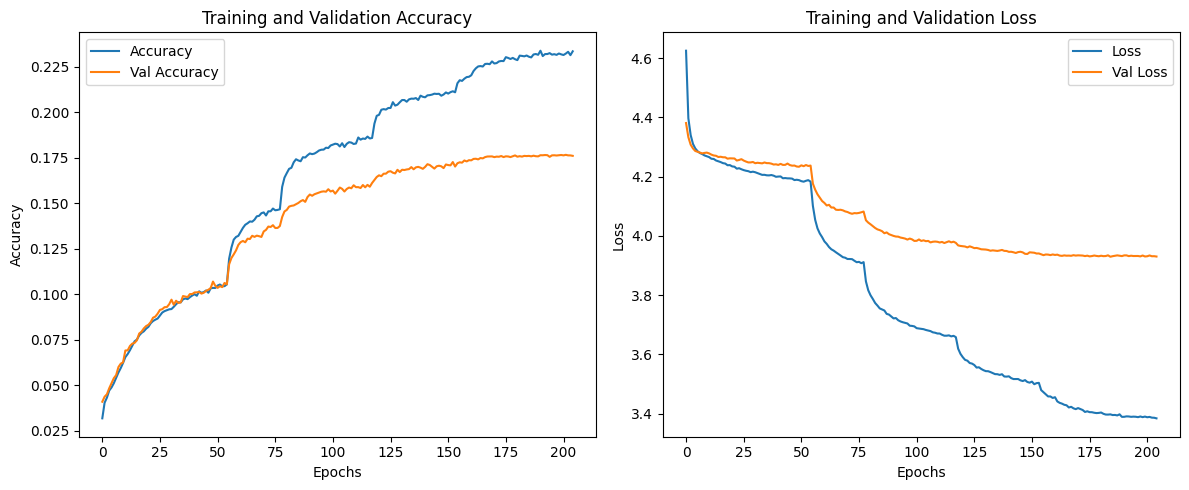

In [10]:
# Récupération des données d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Création de la figure
plt.figure(figsize=(12, 5))

# Plot de l'accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot de la loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Affichage
plt.tight_layout()
plt.show()

In [11]:
X_train_preproc = pipeline.fit_transform(X_train)

X_test_preproc = pipeline.transform(X_test)
y_test_cat = to_categorical(y_test)

model.evaluate(X_test_preproc, y_test_cat, verbose=1)

/home/ronan/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


1489/1489 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.1811 - loss: 3.9026


[3.9055421352386475, 0.1813448667526245]

In [15]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 1028)           │       227,188 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1028)           │         4,112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       526,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,747,562 (10.48 MB)

 Trainable params: 914,656 (3.49 MB)

 Non-trainable params: 3,592 (14.03 KB)

 Optimizer params: 1,829,314 (6.98 MB)

In [16]:
model.predict(X_test_preproc)

1489/1489 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


array([[1.4728852e-05, 1.6469178e-06, 2.8369266e-06, ..., 1.1060507e-03,
        2.8440959e-03, 6.1319146e-04],
       [4.5410564e-04, 5.4695737e-04, 4.4398417e-04, ..., 1.5494531e-03,
        2.8662600e-03, 1.2356058e-03],
       [5.7066800e-06, 3.9892751e-05, 1.8854428e-04, ..., 8.0533446e-06,
        8.4264502e-06, 1.9222634e-05],
       ...,
       [1.1569209e-02, 2.6440857e-02, 1.7308414e-02, ..., 6.3024298e-04,
        6.0556637e-04, 7.8014546e-04],
       [5.0332518e-03, 4.2197281e-03, 7.1181445e-03, ..., 3.7407710e-03,
        6.5119020e-03, 2.5774199e-03],
       [5.0566887e-04, 4.4657392e-04, 2.9559204e-04, ..., 3.0723207e-03,
        3.2012258e-03, 9.2106164e-03]], dtype=float32)

In [18]:
import os

model_name = 'model_montant_100.h5'
model.save(os.path.join(MODEL_PATH,model_name))

In [36]:
from keras.models import load_model

model_name = 'model_montant_100.keras'

model_loaded = load_model(os.path.join(MODEL_PATH,model_name))  

model_loaded.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 1028)           │       227,188 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1028)           │         4,112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       526,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,747,562 (10.48 MB)

 Trainable params: 914,656 (3.49 MB)

 Non-trainable params: 3,592 (14.03 KB)

 Optimizer params: 1,829,314 (6.98 MB)

In [20]:
pred = model.predict(X_test_preproc)

1489/1489 ━━━━━━━━━━━━━━━━━━━━ 1s 598us/step


In [21]:
pred[0]

array([1.47288520e-05, 1.64691778e-06, 2.83692657e-06, 2.53215580e-06,
       2.73073942e-06, 1.58271050e-05, 7.32090655e-07, 1.64977882e-06,
       1.98989551e-06, 1.22467309e-05, 1.13345268e-04, 1.36341464e-06,
       3.47026908e-05, 7.09318192e-05, 1.84994715e-05, 2.54170609e-05,
       1.12461275e-04, 1.11052526e-04, 8.20364403e-06, 3.45023341e-06,
       3.73208095e-05, 1.92509415e-05, 2.61174023e-06, 7.89032783e-04,
       8.66164919e-05, 1.50417009e-05, 1.67886647e-05, 4.03741842e-06,
       2.31793219e-05, 3.99470518e-05, 2.74337399e-05, 2.34789218e-06,
       4.33761379e-05, 1.64764875e-04, 4.33903415e-06, 1.11366346e-04,
       3.09576601e-04, 3.30688340e-06, 7.26757789e-05, 7.83568394e-05,
       2.32219572e-05, 8.21327697e-03, 1.11050511e-04, 2.54138256e-04,
       1.47046558e-05, 1.88361024e-04, 1.29829532e-05, 2.48288452e-05,
       6.69077126e-05, 5.61978559e-05, 5.71496785e-05, 8.28785356e-03,
       5.04909112e-05, 1.92135005e-04, 2.22269897e-04, 7.82066345e-05,
      

In [22]:
bins

array([ 9.90353755,  9.94265728,  9.98177701, 10.02089674, 10.06001647,
       10.0991362 , 10.13825593, 10.17737566, 10.21649539, 10.25561512,
       10.29473485, 10.33385458, 10.37297431, 10.41209404, 10.45121377,
       10.4903335 , 10.52945323, 10.56857296, 10.60769269, 10.64681242,
       10.68593215, 10.72505188, 10.76417161, 10.80329134, 10.84241107,
       10.8815308 , 10.92065053, 10.95977026, 10.99888999, 11.03800972,
       11.07712945, 11.11624918, 11.15536891, 11.19448864, 11.23360837,
       11.2727281 , 11.31184783, 11.35096756, 11.39008729, 11.42920702,
       11.46832675, 11.50744648, 11.54656621, 11.58568594, 11.62480567,
       11.6639254 , 11.70304513, 11.74216486, 11.78128459, 11.82040432,
       11.85952405, 11.89864378, 11.93776351, 11.97688324, 12.01600297,
       12.0551227 , 12.09424244, 12.13336217, 12.1724819 , 12.21160163,
       12.25072136, 12.28984109, 12.32896082, 12.36808055, 12.40720028,
       12.44632001, 12.48543974, 12.52455947, 12.5636792 , 12.60

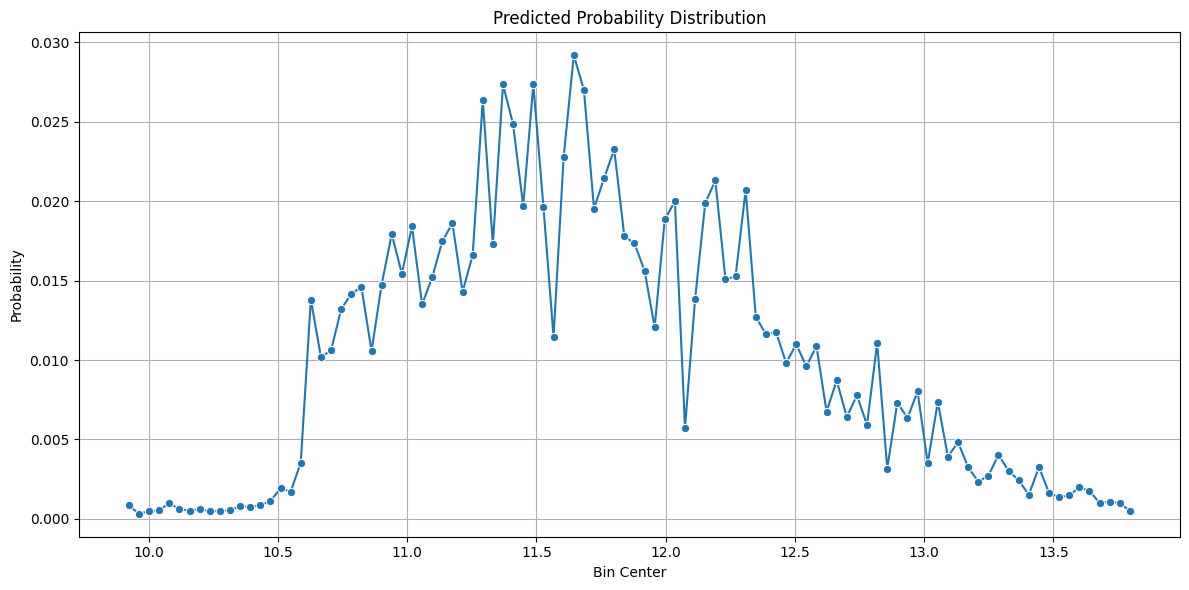

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

id = 50

# Compute bin centers
bin_centers = 0.5 * (bins[:-1] + bins[1:])  # shape (100,)

# Prepare DataFrame for plotting
df = pd.DataFrame({'bin_center': bin_centers, 'probability': pred[id]})

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='bin_center', y='probability', marker='o')
plt.title("Predicted Probability Distribution")
plt.xlabel("Bin Center")
plt.ylabel("Probability")
plt.grid(True)
plt.tight_layout()
plt.show()


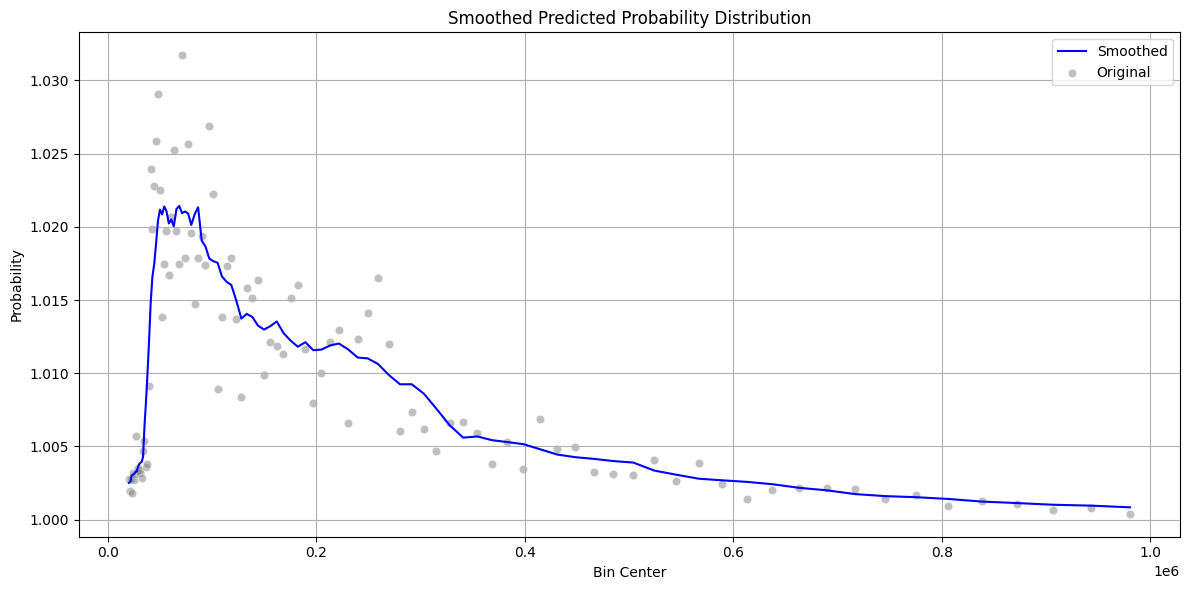

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

id = 10

# Compute bin centers
bin_centers = 0.5 * (bins[:-1] + bins[1:])  # shape (100,)

# Prepare DataFrame for plotting
df = pd.DataFrame({'bin_center': np.exp(bin_centers), 'probability': np.exp(pred[id])})

# Add a smoothed version using a rolling mean
df['smoothed'] = df['probability'].rolling(window=10, center=True, min_periods=1).mean()

# Plot both for comparison
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='bin_center', y='smoothed', label='Smoothed', color='blue')
sns.scatterplot(data=df, x='bin_center', y='probability', color='gray', alpha=0.5, label='Original')
plt.title("Smoothed Predicted Probability Distribution")
plt.xlabel("Bin Center")
plt.ylabel("Probability")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()